### Imports
Import these packages to the project.

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 30.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
!pip install keras tensorflow matplotlib numpy

In [ ]:
from __future__ import division
import numpy as np
import os
import glob

from random import *
from PIL import Image
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization
from keras.layers import Conv2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam, RMSprop

These are the forms in the dataset for quick access from manipulation of the file names on each column. Let's create a dictionary with form and writer mapping.

In [ ]:
d = {}
from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))
# forms = pd.read_csv('../input/iam-handwriting-top50/forms_for_parsing.txt', header=None)
# print(forms.head)
with open('/content/drive/MyDrive/OneWeb Projects/Handwriting Recognition CNN/forms_for_parsing.txt') as f:
    for line in f:
        key = line.split(' ')[0]
        writer = line.split(' ')[1]
        d[key] = writer
print(len(d.keys()))

1539


All file-names list and target-writer names list are created.

In [ ]:
tmp = []
target_list = []

path_to_files = os.path.join('/content/drive/MyDrive/OneWeb Projects/Handwriting Recognition CNN/data_subset/data_subset', '*')
for filename in sorted(glob.glob(path_to_files)):
#     print(filename)
    tmp.append(filename)
    image_name = filename.split('/')[-1]
    file, ext = os.path.splitext(image_name)
    parts = file.split('-')
    form = parts[0] + '-' + parts[1]
    for key in d:
        if key == form:
            target_list.append(str(d[form]))

img_files = np.asarray(tmp)
img_targets = np.asarray(target_list)
print(img_files.shape)
print(img_targets.shape)

(4899,)
(4899,)


### Visualization of images
Let's visualize the image data.

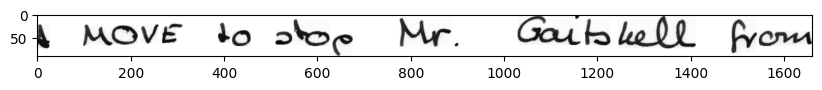

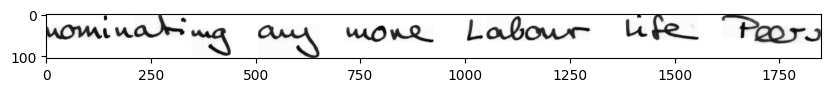

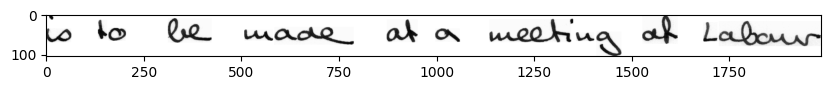

In [ ]:
for filename in img_files[:3]:
    img=mpimg.imread(filename)
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap ='gray')

Good to observe that there are no categorical data. So, normalisation is done using label encoder.

In [ ]:
encoder = LabelEncoder()
encoder.fit(img_targets)
encoded_Y = encoder.transform(img_targets)

print(img_files[:5], img_targets[:5], encoded_Y[:5])

['/content/drive/MyDrive/OneWeb Projects/Handwriting Recognition CNN/data_subset/data_subset/a01-000u-s00-00.png'
 '/content/drive/MyDrive/OneWeb Projects/Handwriting Recognition CNN/data_subset/data_subset/a01-000u-s00-01.png'
 '/content/drive/MyDrive/OneWeb Projects/Handwriting Recognition CNN/data_subset/data_subset/a01-000u-s00-02.png'
 '/content/drive/MyDrive/OneWeb Projects/Handwriting Recognition CNN/data_subset/data_subset/a01-000u-s00-03.png'
 '/content/drive/MyDrive/OneWeb Projects/Handwriting Recognition CNN/data_subset/data_subset/a01-000u-s01-00.png'] ['000' '000' '000' '000' '000'] [0 0 0 0 0]


Splitting of data into training and validation sets for cross validation with 4:1:1 ratio.

In [ ]:
train_files, rem_files, train_targets, rem_targets = train_test_split(
        img_files, encoded_Y, train_size=0.66, random_state=52, shuffle= True)

validation_files, test_files, validation_targets, test_targets = train_test_split(
        rem_files, rem_targets, train_size=0.5, random_state=22, shuffle=True)

print(train_files.shape, validation_files.shape, test_files.shape)
print(train_targets.shape, validation_targets.shape, test_targets.shape)

(3233,) (833,) (833,)
(3233,) (833,) (833,)


### Input to the model

As said before, we take patches of data, each of size 113x133. A generator function is implemented for that purpose.

In [ ]:
# Generator function for generating random crops from each sentence

# # Now create generators for randomly cropping 113x113 patches from these images

batch_size = 8 #16
num_classes = 50

# Start with train generator shared in the class and add image augmentations
def generate_data(samples, target_files,  batch_size=batch_size, factor = 0.1 ):
    num_samples = len(samples)
    from sklearn.utils import shuffle
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            batch_targets = target_files[offset:offset+batch_size]

            images = []
            targets = []
            for i in range(len(batch_samples)):
                batch_sample = batch_samples[i]
                batch_target = batch_targets[i]
                im = Image.open(batch_sample)
                cur_width = im.size[0]
                cur_height = im.size[1]

                # print(cur_width, cur_height)
                height_fac = 113 / cur_height

                new_width = int(cur_width * height_fac)
                size = new_width, 113

                imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio
                now_width = imresize.size[0]
                now_height = imresize.size[1]
                # Generate crops of size 113x113 from this resized image and keep random 10% of crops

                avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

                # Pick random x%
                pick_num = int(len(avail_x_points)*factor)

                # Now pick
                random_startx = sample(avail_x_points,  pick_num)

                for start in random_startx:
                    imcrop = imresize.crop((start, 0, start+113, 113))
                    images.append(np.asarray(imcrop))
                    targets.append(batch_target)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(targets)

            #reshape X_train for feeding in later
            X_train = X_train.reshape(X_train.shape[0], 113, 113, 1)
            #convert to float and normalize
            X_train = X_train.astype('float32')
            X_train /= 255

            #One hot encode y
            y_train = to_categorical(y_train, num_classes)
            yield shuffle(X_train, y_train)

For training and testing,  generator function is called with the intent of making train and test generator data.

In [ ]:
train_generator = generate_data(train_files, train_targets, batch_size=batch_size, factor = 0.3)
validation_generator = generate_data(validation_files, validation_targets, batch_size=batch_size, factor = 0.3)
test_generator = generate_data(test_files, test_targets, batch_size=batch_size, factor = 0.1)

A Keras Model is built. Summary of the model is printed below.

In [ ]:
def resize_image(image):
    import tensorflow as tf
    return tf.image.resize(image,[56,56])

# Function to resize image to 64x64
row, col, ch = 113, 113, 1

model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(row, col, ch)))

# Resise data within the neural network
model.add(Lambda(resize_image))  #resize images to allow for easy computation

# CNN model - Building the model suggested in paper


model.add(Conv2D(filters= 32, kernel_size =(5,5), strides= (2,2), padding='same', name='conv1')) #96
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool1'))

model.add(Conv2D(filters= 64, kernel_size =(3,3), strides= (1,1), padding='same', name='conv2'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool2'))

model.add(Conv2D(filters= 128, kernel_size =(3,3), strides= (1,1), padding='same', name='conv3'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool3'))


model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(512, name='dense1'))  #1024
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256, name='dense2'))  #1024
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes,name='output'))
model.add(Activation('softmax'))  #softmax since output is within 50 classes

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPaddin  (None, 115, 115, 1)       0         
 g2D)                                                            
                                                                 
 lambda (Lambda)             (None, 56, 56, 1)         0         
                                                                 
 conv1 (Conv2D)              (None, 28, 28, 32)        832       
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 14, 14, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 14, 14, 64)        18496     
                                                        

### Training the model

Let's take 8 epochs. And the following specifications.

In [14]:
nb_epoch = 12

samples_per_epoch = 3268
nb_val_samples = 842

# #save every model using Keras checkpoint
from keras.callbacks import ModelCheckpoint
#filepath="check-{epoch:02d}-{val_loss:.4f}.hdf5"
filepath="low_loss.hdf5"
checkpoint = ModelCheckpoint(filepath= filepath, verbose=1, save_best_only=False)
callbacks_list = [checkpoint]

# #Model fit generator
history_object = model.fit_generator(train_generator, steps_per_epoch = samples_per_epoch/batch_size,
                                      validation_data=validation_generator,
                                      validation_steps=nb_val_samples, epochs=nb_epoch, verbose=1, callbacks=callbacks_list)

<ipython-input-14-b7bdd57e86d7>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_object = model.fit_generator(train_generator, steps_per_epoch = samples_per_epoch/batch_size,
<ipython-input-10-25774654e0fd>:32: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio


Epoch 1/12
409/408 [==============================] - ETA: -1s - loss: 3.6161 - accuracy: 0.2079
Epoch 1: saving model to low_loss.hdf5
408/408 [==============================] - 1502s 4s/step - loss: 3.6161 - accuracy: 0.2079 - val_loss: 3.1738 - val_accuracy: 0.2413
Epoch 2/12


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


409/408 [==============================] - ETA: 0s - loss: 2.8677 - accuracy: 0.2506
Epoch 2: saving model to low_loss.hdf5
408/408 [==============================] - 580s 1s/step - loss: 2.8677 - accuracy: 0.2506 - val_loss: 2.5037 - val_accuracy: 0.2977
Epoch 3/12
409/408 [==============================] - ETA: 0s - loss: 2.4065 - accuracy: 0.3111
Epoch 3: saving model to low_loss.hdf5
408/408 [==============================] - 581s 1s/step - loss: 2.4065 - accuracy: 0.3111 - val_loss: 2.0811 - val_accuracy: 0.3789
Epoch 4/12
409/408 [==============================] - ETA: 0s - loss: 2.1076 - accuracy: 0.3788
Epoch 4: saving model to low_loss.hdf5
408/408 [==============================] - 631s 2s/step - loss: 2.1076 - accuracy: 0.3788 - val_loss: 1.7741 - val_accuracy: 0.4498
Epoch 5/12
409/408 [==============================] - ETA: 0s - loss: 1.8735 - accuracy: 0.4398
Epoch 5: saving model to low_loss.hdf5
408/408 [==============================] - 575s 1s/step - loss: 1.8735 - ac

### Performance Metrics

Let's now test our model for calculating accuracy.

In [ ]:
model.load_weights('low_loss.hdf5')
scores = model.evaluate(test_generator, steps=842)
print("Accuracy = ", scores[1])

<ipython-input-10-25774654e0fd>:32: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio


356/842 [===========>..................] - ETA: 1:41 - loss: 0.9751 - accuracy: 0.7037

Load in test data.

In [16]:
images = []
for filename in test_files[:50]:
     im = Image.open(filename)
     cur_width = im.size[0]
     cur_height = im.size[1]

     print(cur_width, cur_height)
     height_fac = 113 / cur_height

     new_width = int(cur_width * height_fac)
     size = new_width, 113

     imresize = im.resize((size), Image.LANCZOS)
     # Resize so height = 113 while keeping aspect ratio
     now_width = imresize.size[0]
     now_height = imresize.size[1]
     # Generate crops of size 113x113 from this resized image and keep random 10% of crops

     avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

     # Pick random x%
     factor = 0.1
     pick_num = int(len(avail_x_points)*factor)

     random_startx = sample(avail_x_points,  pick_num)

     for start in random_startx:
         imcrop = imresize.crop((start, 0, start+113, 113))
         images.append(np.asarray(imcrop))

     X_test = np.array(images)

     X_test = X_test.reshape(X_test.shape[0], 113, 113, 1)
     #convert to float and normalize
     X_test = X_test.astype('float32')
     X_test /= 255
     shuffle(X_test)

     print(X_test.shape)

866 147
(55, 113, 113, 1)
1814 84
(287, 113, 113, 1)
813 105
(363, 113, 113, 1)
1871 160
(483, 113, 113, 1)
1037 83
(612, 113, 113, 1)
1228 66
(810, 113, 113, 1)
1702 101


<ipython-input-16-624a29e69ca5>:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio


(989, 113, 113, 1)
329 115
(1010, 113, 113, 1)
499 75
(1073, 113, 113, 1)
1683 93
(1266, 113, 113, 1)
717 76
(1361, 113, 113, 1)
149 88
(1368, 113, 113, 1)
1031 121
(1452, 113, 113, 1)
644 61
(1559, 113, 113, 1)
2029 81
(1830, 113, 113, 1)
870 77
(1946, 113, 113, 1)
1822 118
(2109, 113, 113, 1)
1837 137
(2249, 113, 113, 1)
1638 117
(2395, 113, 113, 1)
424 49
(2481, 113, 113, 1)
667 110
(2538, 113, 113, 1)
654 77
(2622, 113, 113, 1)
1217 74
(2796, 113, 113, 1)
441 111
(2829, 113, 113, 1)
386 66
(2883, 113, 113, 1)
1351 87
(3047, 113, 113, 1)
1928 145
(3185, 113, 113, 1)
1876 73
(3464, 113, 113, 1)
2025 117
(3648, 113, 113, 1)
826 85
(3746, 113, 113, 1)
1824 171
(3855, 113, 113, 1)
1843 143
(3989, 113, 113, 1)
1098 150
(4060, 113, 113, 1)
1721 113
(4220, 113, 113, 1)
1743 103
(4399, 113, 113, 1)
1730 167
(4504, 113, 113, 1)
1843 122
(4663, 113, 113, 1)
1719 126
(4805, 113, 113, 1)
1201 151
(4883, 113, 113, 1)
735 177
(4918, 113, 113, 1)
1717 113
(5078, 113, 113, 1)
1507 129
(5198, 113, 1

### Predictions

In [17]:
predictions = model.predict(X_test, verbose =1)

print(predictions.shape)
predicted_writer = []
for pred in predictions:
    predicted_writer.append(np.argmax(pred))
    print(len(predicted_writer))

Streaming output truncated to the last 5000 lines.
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541

### Insights

In [18]:
writer_number = 18
total_images =10
counter = 0
for i in range(len(predicted_writer)//10):
     if predicted_writer[i] == writer_number:
         image = X_test[i].squeeze()
         plt.figure(figsize=(2,2))
         plt.imshow(image, cmap ='gray')

In [ ]:
def preprocess_image(image_path, target_size=(113, 113)):
    img = Image.open(image_path)
    img = img.resize(target_size, Image.LANCZOS)
    img_array = np.asarray(img)
    img_array = img_array.astype('float32')
    img_array /= 255
    return img_array.reshape(1, target_size[0], target_size[1], 1)  # Reshape for model input



In [ ]:
def convert_prediction_to_text(prediction, label_mapping):

    # Find the index of the highest probability in the prediction
    predicted_index = np.argmax(prediction, axis=1)
    # Convert index to character using the label mapping
    predicted_characters = [label_mapping[index] for index in predicted_index]
    # Combine characters into a string
    predicted_text = ''.join(predicted_characters)
    return predicted_text


In [ ]:
def predict_text(model, image_path):
    processed_image = preprocess_image(image_path)
    prediction = model.predict(processed_image)
    # Convert prediction to text - this step depends on your label encoding
    predicted_text = convert_prediction_to_text(prediction)  # Implement this function
    return predicted_text
